# Packages

In [24]:
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas.tools import sjoin
from shapely.geometry import Point, MultiPolygon, Polygon
from shapely import wkt
%matplotlib inline
import time
import folium
import json
from copy import copy
import fiona 

# Import French polygons

In [33]:
%%time
# Note: Download https://drive.google.com/file/d/1RI4juYebKMGOJsSUQGYrL0zjLw55b5Ze/view?usp=share_link and update above path to the location of the gpkg file
path = '../data/raw/reglementation-des-peches-cartographiee.gpkg'

lay_list = []

for layername in fiona.listlayers(path):  # https://stackoverflow.com/questions/56165069/can-geopandas-get-a-geopackages-or-other-vector-file-all-layers
    geopkg = gpd.read_file(path, layer=layername)
    lay_list.append(geopkg)

polys = pd.concat(lay_list, ignore_index=True)


CPU times: user 1.65 s, sys: 155 ms, total: 1.8 s
Wall time: 1.94 s


In [34]:
polys

,type_de_reglementation,thematique,zone,reglementations,geometry
0,Reg. NAMO,Côtes d'Armor - CSJ,Banc de Maërl - Zone interdite à la pêche,Arrêté Préfectoral R3-2022-09-15-00004 - Délib...,"MULTIPOLYGON (((-3.43414 48.83543, -3.41475 48..."
1,Reg. NAMO,Côtes d'Armor - CSJ - plongée,Gisement Rance Côte d'Armor soumis à licence,Arrêté Préfectoral R53-2022-09-22-00003 - déli...,"MULTIPOLYGON (((-2.00277 48.57144, -2.00214 48..."
2,Reg. NAMO,Côtes d'Armor - CSJ - plongée,Gisement Rance de Saint-Malo soumis à licence ...,Arrêté Préfectoral R3-2022-09-15-00001 - Délib...,"MULTIPOLYGON (((-2.02304 48.61657, -2.02263 48..."
3,Reg. NAMO,Lorient - CSJ - Dragues,Lorient-Groix - pêche soumise à une licence,Arrêté Préfectoral R53-2019-04-18-006 / Délib ...,"MULTIPOLYGON (((-3.41809 47.63500, -3.41830 47..."
4,Reg. NAMO,Lorient - CSJ - Dragues,Banc de Maërl - interdiction de pêche,Arrêté Préfectoral R53-2019-04-18-006 / Délib ...,"MULTIPOLYGON (((-3.43634 47.64771, -3.43555 47..."
...,...,...,...,...,...
877,R(UE) 2022/1614,Atlantique 400m - Ecosystèmes Marins Vulnérabl...,Interdiction de pêche aux engins de fond 1,RE(UE) 2022/1614,"MULTIPOLYGON (((-8.07500 36.27500, -8.05000 36..."
878,R(UE) 2022/1614,Atlantique 400m - Ecosystèmes Marins Vulnérabl...,Interdiction de pêche aux engins de fond 2,"R (UE) 2016/2336 , RE(UE) 2022/1614","MULTIPOLYGON (((-15.44030 55.60760, -15.43780 ..."
879,R(UE) 2022/1614,Atlantique 800m - Ecosystèmes marins vulnérabl...,Zones existantes de pêche en eau profonde,"RE(UE) 2022/1614, R (UE) 2016/2336","MULTIPOLYGON (((-6.75000 35.90000, -6.75000 35..."
880,Reg. CCAMLR,Atlantique - Légine - Palangre,Campagne exploratoire SAINT ANDRE - 28.5 tonnes,Autorisation de pêche exploratoire / CCAMLR,"MULTIPOLYGON (((50.00000 -66.50000, 50.00000 -..."


<AxesSubplot:>

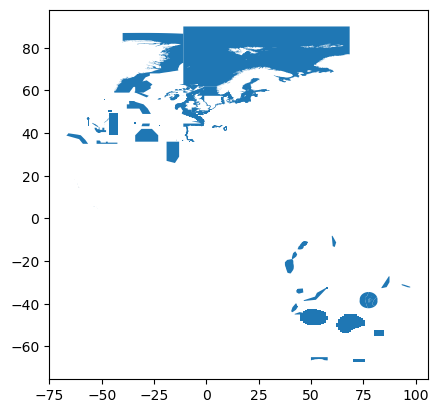

In [35]:
polys.plot()

# Create test points DFs, with points inside and outside of WDPAs

### Some positive points inside Bassin d'Arcachon

In [9]:
pts_test = gpd.GeoDataFrame({'ship_name':['arc1','arc2','arc3','gir_inland','canarias1'],
                             'timestamp':['1066-01-01 01:01'] * 5 },
                            geometry=gpd.points_from_xy([-1.130158,
                                                        -1.146638,
                                                        -1.223542,
                                                        0.905394,
                                                        -16.103645,],
                                                        [44.696739,
                                                        44.729920, 
                                                        44.626411,
                                                        43.638630,
                                                        28.460471,]),
                            crs='epsg:4326')

# arc1, arc2, arc3 are in Bassin d'Arcachon
# gir_inland is not inside the Bassing d'Arcachon (random point in Gironde)

### Points from Marion/Ronan CSV 

In [10]:
pts_bloom = pd.read_csv('../../bloom_scrap.csv') 
# Relative path to the file based on structure of GH repo

In [11]:
# Turn into geopandas dataframe
pts_bloom = gpd.GeoDataFrame(
    pts_bloom, geometry=gpd.points_from_xy(pts_bloom.Longitude, pts_bloom.Latitude),
    crs = 4326 # set the coordinate system to ESPG:4326, same as `poly`
)

In [12]:
pts_bloom.head()

,timestamp,ship_name,IMO,Time of latest position,Latitude,Longitude,geometry
0,2023-01-05 10:57,AFRIKA,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-3.49179 60.08667)
1,2023-01-05 10:58,AFRIKA,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-3.49179 60.08667)
2,2023-01-05 11:10,AFRIKA,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-3.49179 60.08667)
3,2023-01-05 11:19,AFRIKA,9175834,2023-01-05 10:11 UTC,60.02838,-3.606985,POINT (-3.60698 60.02838)
4,2023-01-05 11:27,AFRIKA,9175834,2023-01-05 10:11 UTC,60.02838,-3.606985,POINT (-3.60698 60.02838)


##### Adding an artificial positive points to pts_bloom

In [13]:
add_row = copy(pts_bloom.iloc[[0]])
add_row['ship_name'] = 'ARTIFICIAL'
add_row['geometry'] = pts_test['geometry'][0]
add_row['timestamp'] = pts_test['timestamp'][0]

pts_bloom_plus_pos = gpd.GeoDataFrame(pd.concat([pts_bloom, add_row]), 
                                      crs = 4326 # set the coordinate system to ESPG:4326, same as `poly`
                                      ) 


# Check whether a (set of) points are in a (set of) polygons

Note: the `sjoin` (and other join) methods require an up to date version of geopandas. 
See https://stackoverflow.com/questions/70393202/why-is-my-geopandas-installation-missing-sjoin-attributeerror-geodataframe-o:
"old version of geopandas.... github.com/geopandas/geopandas/releases requires v0.10.0+"

I am only showcasing here the very simple and efficient vectorized "join" method suggested by Samuel.
(https://data-for-good.slack.com/archives/C04MVJS7E3Z/p1676913949126249?thread_ts=1676830741.313179&cid=C04MVJS7E3Z)
(https://geopandas.org/en/stable/gallery/spatial_joins.html)

For reference, the basic non-vectorized `shapely` method to check whether a polygon contains a point is `contain`.
See https://stackoverflow.com/a/36400130/14095529.

In [36]:
match_test = pts_test.sjoin(polys, how="left")

In [40]:
match_bloom = pts_bloom.sjoin(polys, how="left")

In [41]:
match_bloom_plus = pts_bloom_plus_pos.sjoin(polys, how="left")

In [39]:
match_test

,ship_name,timestamp,geometry,index_right,type_de_reglementation,thematique,zone,reglementations
0,arc1,1066-01-01 01:01,POINT (-1.13016 44.69674),524.0,Reg. SA,Aquitaine - Céphalopodes,"Licence ""céphalopodes aux arts traînants"" requise",Arrêté Préfectoral du 28/08/2018 - Délib 2018-...
0,arc1,1066-01-01 01:01,POINT (-1.13016 44.69674),514.0,Reg. SA,Aquitaine - Filets,"Licence ""Bolinche"" requise",Arrêté Préfectoral du 28/08/2018 - Délib 2018-...
0,arc1,1066-01-01 01:01,POINT (-1.13016 44.69674),535.0,Reg. SA,Aquitaine - Chaluts,"Licence ""25 m hors-tout et 400kw"" requise",Arrêté Préfectoral du 28/08/2018 - Délib 2018-...
0,arc1,1066-01-01 01:01,POINT (-1.13016 44.69674),531.0,Reg. SA,Aquitaine - Chaluts,Zone d'interdiction chalut,Arrêté 237 du 20/10/1975 / SA
0,arc1,1066-01-01 01:01,POINT (-1.13016 44.69674),508.0,Reg. SA,Arcachon - Dragues - Moules et Pétoncles,Licence requise,Arrêté Préfectoral du 15/12/2015 - délib 2015-...
0,arc1,1066-01-01 01:01,POINT (-1.13016 44.69674),507.0,Reg. SA,Arcachon - Engins dormants,Licence Intra-bassin AC requise,Arrêté Préfectoral du 19/12/2017 - Délib 2017-...
0,arc1,1066-01-01 01:01,POINT (-1.13016 44.69674),525.0,Reg. SA,SA Chaluts GOV,SA autorisation ponctuelle,Arrêté Ministériel 1750 P-3 du 19/06/1980 cons...
0,arc1,1066-01-01 01:01,POINT (-1.13016 44.69674),860.0,R(UE) 2019/1241,EOA Filets-fixe,Merlu - Filets maillants de fond 2,R(UE) 2019/1241
0,arc1,1066-01-01 01:01,POINT (-1.13016 44.69674),858.0,R(UE) 2019/1241,EOA Filets-fixe,Baudroie - Filets emmêlants,R(UE) 2019/1241
1,arc2,1066-01-01 01:01,POINT (-1.14664 44.72992),524.0,Reg. SA,Aquitaine - Céphalopodes,"Licence ""céphalopodes aux arts traînants"" requise",Arrêté Préfectoral du 28/08/2018 - Délib 2018-...


In [42]:
match_bloom

,timestamp,ship_name,IMO,Time of latest position,Latitude,Longitude,geometry,index_right,type_de_reglementation,thematique,zone,reglementations
0,2023-01-05 10:57,AFRIKA,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-3.49179 60.08667),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
1,2023-01-05 10:58,AFRIKA,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-3.49179 60.08667),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
2,2023-01-05 11:10,AFRIKA,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-3.49179 60.08667),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
3,2023-01-05 11:19,AFRIKA,9175834,2023-01-05 10:11 UTC,60.02838,-3.606985,POINT (-3.60698 60.02838),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
4,2023-01-05 11:27,AFRIKA,9175834,2023-01-05 10:11 UTC,60.02838,-3.606985,POINT (-3.60698 60.02838),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
...,...,...,...,...,...,...,...,...,...,...,...,...
111,2023-01-05 18:37,SCOMBRUS,9828936,2023-01-05 17:40 UTC,52.09985,4.266627,POINT (4.26663 52.09985),NaN,NaN,NaN,NaN,NaN
112,2023-01-05 18:37,WILLEM VAN DER ZWAN,9187306,2023-01-05 17:39 UTC,51.46196,3.699590,POINT (3.69959 51.46196),NaN,NaN,NaN,NaN,NaN
113,2023-01-05 18:37,WIRON5.H1100,9249556,2023-01-05 17:42 UTC,50.66199,0.567013,POINT (0.56701 50.66199),850.0,R(UE) 2019/1241,Royaume-Uni Chalut-à-perches,Royaume-Uni 12 milles,R(UE) 2019/1241 Modifié
114,2023-01-05 18:37,NaN,9249568,NaN,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,NaN,NaN


In [43]:
match_bloom_plus

,timestamp,ship_name,IMO,Time of latest position,Latitude,Longitude,geometry,index_right,type_de_reglementation,thematique,zone,reglementations
0,2023-01-05 10:57,AFRIKA,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-3.49179 60.08667),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
1,2023-01-05 10:58,AFRIKA,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-3.49179 60.08667),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
2,2023-01-05 11:10,AFRIKA,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-3.49179 60.08667),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
3,2023-01-05 11:19,AFRIKA,9175834,2023-01-05 10:11 UTC,60.02838,-3.606985,POINT (-3.60698 60.02838),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
4,2023-01-05 11:27,AFRIKA,9175834,2023-01-05 10:11 UTC,60.02838,-3.606985,POINT (-3.60698 60.02838),845.0,R(UE) 2019/1241,Mer-du-Nord Filets-fixes,Filets fixes dans les divisions CIEM 3a et 4a,R(UE) 2019/1241 Modifié
...,...,...,...,...,...,...,...,...,...,...,...,...
0,1066-01-01 01:01,ARTIFICIAL,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-1.13016 44.69674),508.0,Reg. SA,Arcachon - Dragues - Moules et Pétoncles,Licence requise,Arrêté Préfectoral du 15/12/2015 - délib 2015-...
0,1066-01-01 01:01,ARTIFICIAL,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-1.13016 44.69674),507.0,Reg. SA,Arcachon - Engins dormants,Licence Intra-bassin AC requise,Arrêté Préfectoral du 19/12/2017 - Délib 2017-...
0,1066-01-01 01:01,ARTIFICIAL,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-1.13016 44.69674),525.0,Reg. SA,SA Chaluts GOV,SA autorisation ponctuelle,Arrêté Ministériel 1750 P-3 du 19/06/1980 cons...
0,1066-01-01 01:01,ARTIFICIAL,9175834,2023-01-05 08:51 UTC,60.08667,-3.491793,POINT (-1.13016 44.69674),860.0,R(UE) 2019/1241,EOA Filets-fixe,Merlu - Filets maillants de fond 2,R(UE) 2019/1241
